# Proxy model intro

## Standard imports

First, set up some standard modules and matplotlib.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import matplotlib.pyplot as plt

In [2]:
import numpy as np
import regressproxy

## Proxy interface

We create a mock proxy time series to resemble something that might be used to fit time series data.
In the "real" world this may be some kind of index, for example Kp or Ap for geophysical data,
or some economic parameter.

In [3]:
# x is actually the modified Julian day number for the year 2000
xs = 51544.5 + np.arange(0., 1 * 365. + 2, 1.)
ys = np.zeros_like(xs)
ys[20::60] = 1

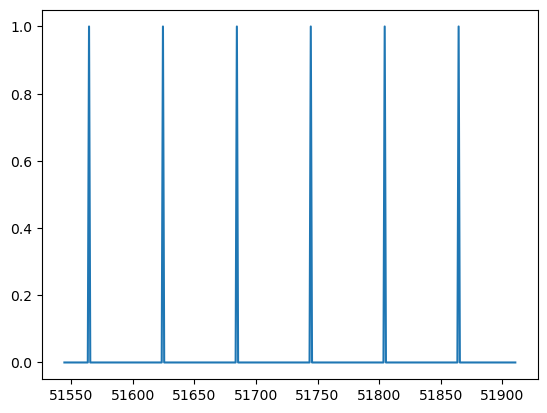

In [4]:
plt.plot(xs, ys)

We use the very peaked time series to setup the proxy model.
In this case it can be seen as isolated events happening at certain times,
here with a fixed amplitude for demonstration.
The `ProxyModel` modifies the original proxy by including a finite decaying lifetime and a lag.
We start with a fixed lag of 2 days and a constant lifetime of 5 days.
The lifetime can be made variable, up to now including annual and semi-annual variations (see below).

In [5]:
proxy = regressproxy.ProxyModel(
    xs,
    ys,
    center=False,
    amp=1,
    lag=2,
    tau0=5,
    taucos1=0, tausin1=0,
    taucos2=0, tausin2=0,
    ltscan=30,
    days_per_time_unit=1.,
)

The full parameter set looks like:

In [6]:
proxy.get_parameter_dict()

OrderedDict([('amp', 1.0),
             ('lag', 2.0),
             ('tau0', 5.0),
             ('taucos1', 0.0),
             ('tausin1', 0.0),
             ('taucos2', 0.0),
             ('tausin2', 0.0),
             ('ltscan', 30.0)])

But we don't need all of them, so we freeze all parameters and thaw the ones we need.
For the first demonstration we keep the amplitude `amp`, the `lag`, and the base lifetime `tau0`.

In [7]:
proxy.freeze_all_parameters()
proxy.thaw_parameter("amp")
proxy.thaw_parameter("lag")
proxy.thaw_parameter("tau0")

Cross check that only the used parameters are really active:

In [8]:
proxy.get_parameter_dict()

OrderedDict([('amp', 1.0), ('lag', 2.0), ('tau0', 5.0)])

According to the parameters, the peaks will be shifted by 2 time units (days) to the right,
and the finite lifetime "dilutes" the peaked proxy values in time.
A similar thing happens if after some event, the specific effect related to that event
persists for some time, which can be different from persistence of an overall effect like
in an autoregressive model.

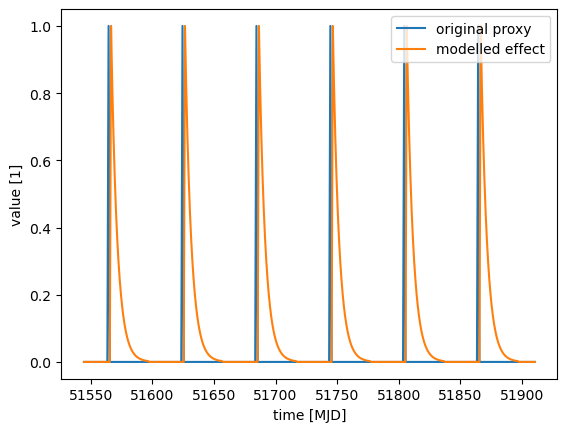

In [9]:
plt.plot(xs, ys, label="original proxy")
plt.plot(xs, proxy.get_value(xs), label="modelled effect")
plt.xlabel("time [MJD]")
plt.ylabel("value [1]")
plt.legend();

For inference, the parameters can be obtained by fitting them to data.

## Model parameters

The parameters can be changed on-line, and
we don't have to set up a new model each time for a new parameter set.
First we "thaw" more parameters and let the lifetime vary with time.

**Note** that this will overwrite the original object's parameters.

In [10]:
proxy.thaw_parameter("taucos1")
proxy.thaw_parameter("tausin1")

In [11]:
proxy.set_parameter_vector([3, 2, 1, 8, 1])
proxy.get_parameter_dict()

OrderedDict([('amp', 3.0),
             ('lag', 2.0),
             ('tau0', 1.0),
             ('taucos1', 8.0),
             ('tausin1', 1.0)])

Technically there is no need to include the `amp` parameter,
the same can be achieved by multiplying the result by the same factor.

In [12]:
pred = proxy.get_value(xs)

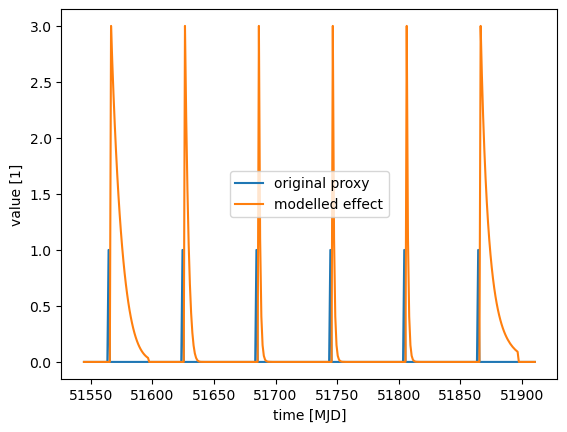

In [13]:
plt.plot(xs, ys, label="original proxy")
plt.plot(xs, pred, label="modelled effect")
plt.xlabel("time [MJD]")
plt.ylabel("value [1]")
plt.legend();

The final "modelled" effect shows that the length of the backward summing might be a bit too short,
we would then adjust the `ltscan` parameter in the model setup.